# Solving the n-Queens Problem using Local Search

## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation (you can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or search algorithms),
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random as rd
from math import e

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0, n, size=n))


# this is n choose 2 equivalent to math.comb(n, 2); // is int division
def comb2(n): return n*(n-1)//2


def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))


def show_board(board, cols=['white', 'gray'], fontsize=48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i, j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap=cmap,
              norm=colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize=fontsize,
                 horizontalalignment='center',
                 verticalalignment='center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()


## Create a board

Board with 4 conflicts.


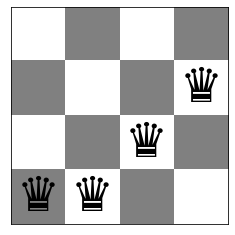

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [2]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")


A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


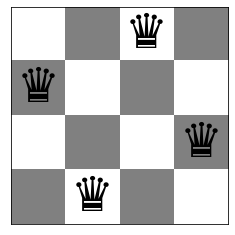

In [3]:
board = [1, 3, 0, 2]
show_board(board)


In [4]:
def expand(i, board):

    moves = [a for a in range(len(board)) if a != i]
    return moves


print(expand(1, board))


[0, 2, 3]


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

Board with 5 conflicts.


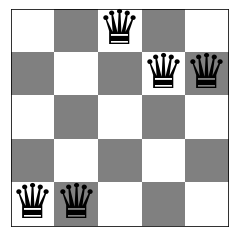

Board with 0 conflicts.


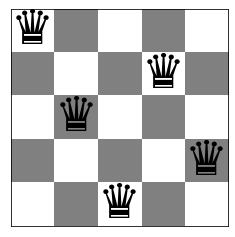

In [5]:
# Code and description go here
'''
THe global minimum at the start would be set to the current board variable.
Also set conflicts(start) as the starting board variable as the current_conflicts variable
For each column in the board, and for each of the nodes in the expansion(given the expand function) in that, calculate the conflicts of each expansion and then pick the one with the minimum.
Do forward iteration and backward iteration and hopefully find the best one which also saves implementation time and space of the implementation

'''
board = random_board(5)


def steepest_hill_climbing(board):
    current = board.copy()
    current_min_conflicts = conflicts(board)
    for column_index in range(len(board)):

        column_moves = expand(current[column_index], current)
        for move in column_moves:
            test_move = current.copy()
            test_move[column_index] = move

            if conflicts(test_move) < current_min_conflicts:
                current = test_move
                current_min_conflicts = conflicts(test_move)
    for column_index in range(len(board)):
        column_moves = expand(current[len(board)-column_index-1], current)
        for move in column_moves:
            test_move = current.copy()
            test_move[len(board)-column_index-1] = move
            if conflicts(test_move) < current_min_conflicts:
                current = test_move
                current_min_conflicts = conflicts(test_move)
    return current


show_board(board)
show_board(steepest_hill_climbing(board))


## Stochastic Hill Climbing 1 [2 Point]

Chooses randomly from among all uphill moves. Make the probability of the choice proportional to the steepness of the uphill move (i.e., with the improvement in conflicts). 

In [64]:
# Code and description go here
'''
First I want to iterate through all of the columns, on each column calculate all of the potential boards with all of their conflicts, put this in a list in order to choose one pbased on the probability function
The list of moves will consist of an array of the current board arrangement and a list of weights and the weights will determine the probability of a pick

'''
board = random_board(15)


def probability_generator(boards, original_conflicts):
    weights = []
    for indx in range(len(boards)):
        weight = abs(original_conflicts-conflicts(boards[indx]))
        weights.append(weight)
    return weights


def stochastic_hill_climbing(board):
    current = board.copy()
    tries = 0
    while (conflicts(current) > 0 and tries < 50):
        tries += 1
        current_min_conflicts = conflicts(board)
        for column_index in range(len(board)):
            column_moves = expand(current[column_index], current)
            moves_list = []

            for move in column_moves:
                row_move = current.copy()
                row_move[column_index] = move
                # Don't even consider a move that is worse, it will mess up the weights and then make it so that sometimes we randomly make it worse
                if conflicts(row_move) < current_min_conflicts:
                    moves_list.append(row_move.copy())

            if moves_list:
                weights = probability_generator(
                    moves_list, current_min_conflicts)
                gen_move = rd.choices(moves_list, weights, k=1)
                current[column_index] = gen_move[0][column_index]
    return current


## Stochastic Hill Climbing 2 [2 Point]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

Board with 4 conflicts.


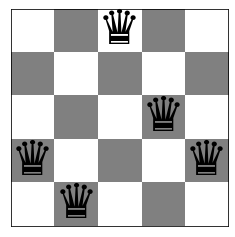

Board with 0 conflicts.


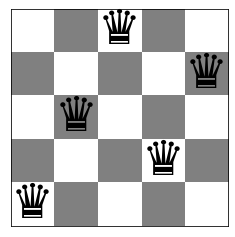

In [63]:
# Code and description go her
'''
Basically just gather a single random and if it decreases number of conflicts from the original board then we use that version of the board
I would like to use the version with 100 tries for testing as well, but for the sake of computation time we will only run thjrough this program once

'''


def random_local_neighbor(board):
    tries = 0

    current = board.copy()
    while(conflicts(current) > 0 and tries < 50):
        tries += 1
        local_minimum = conflicts(board)
        for column_index in range(len(board)):
            column_moves = expand(current[column_index], current)
            move_choice = rd.choice(column_moves)
            test_board = current.copy()
            test_board[column_index] = move_choice
            if conflicts(test_board) < local_minimum:
                local_minimum = conflicts(test_board)
                current = test_board

    return current

board = random_board(5)
show_board(board)

show_board(random_local_neighbor(board))


## Hill Climbing Search with Random Restarts [1 Point]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algoithm several times with a new random initialization.

In [44]:
# Code and description go here
def random_restart(N, algorithm):
    board = random_board(N)
    current = board.copy()
    tries = 0
    complete = False
    min_board = current
    while tries < 100:
        tries += 1
        if complete is False:
            current = algorithm(current)
            if conflicts(current) < conflicts(min_board):
                min_board = current

        if conflicts(min_board) == 0:
            return min_board
        if complete is True:
            break
        current = random_board(N)

    return min_board


steepest_test = random_restart(10, steepest_hill_climbing)
print(conflicts(steepest_test))


0


## Compare Performance [2 Points]

Use runtime and objective function value to compare the algorithms. 

* Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

* How do the algorithms scale with problem size?

* What is the largest board each algorithm can solve in a reasonable amount time?

The example below times creating 100 random boards and calculating the conflicts. Reported is the average run time over `N = 100` runs.

For timing you can use the `time` package.

In [9]:
import time

N = 100
total = 0

for i in range(N):
    t0 = time.time()
    for i in range(1, 100):
        conflicts(random_board(8))
    t1 = time.time()
    total += t1 - t0

tm = total/N

print(f"This took: {tm * 1e3} milliseconds")


This took: 2.846035957336426 milliseconds


The `timit` package is useful to measure time for code that is called repeatedly.

In [10]:
import timeit

N = 100

tm = timeit.timeit('for i in range(1,100): conflicts(random_board(8))',
                   globals=globals(), number=N)/N

print(f"This took: {tm * 1e3} milliseconds")


This took: 3.0598767200012844 milliseconds


Steepest Took: 0.6969118118286133 ms


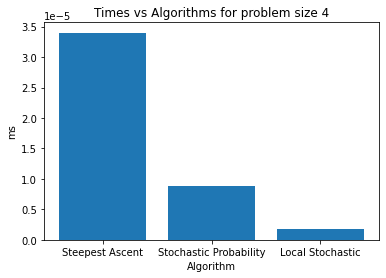

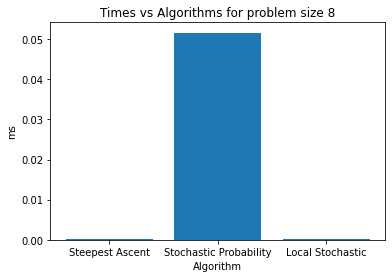

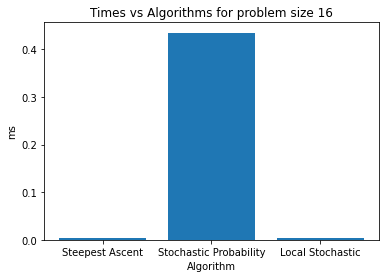

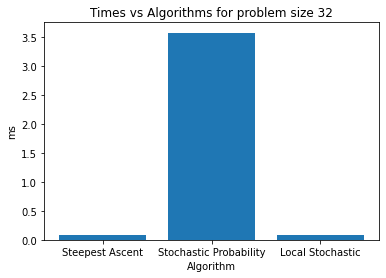

In [65]:
# Code, results, charts and discussion go here

steps = [4, 8, 16, 32]
for i in steps:
    t0_steep = time.time()
    random_restart(i, steepest_hill_climbing)
    t1_steep = time.time()
    steep_time = (t1_steep-t0_steep)/100

    t0_stochastic = time.time()
    random_restart(i, stochastic_hill_climbing)
    t1_stochastic = time.time()
    stochastic_time = (t1_stochastic-t0_stochastic)/100

    t0_local = time.time()
    random_restart(i, random_local_neighbor)
    t1_local = time.time()
    local_time = (t1_local-t0_local)/100

    times = [steep_time, stochastic_time, local_time]
    names = ["Steepest Ascent", "Stochastic Probability", "Local Stochastic"]
    plt.bar(names, times)
    plt.title(f'Times vs Algorithms for problem size {i}')
    plt.xlabel('Algorithm')
    plt.ylabel("ms")
    plt.show()



For these bar graphs we are simply comparing the time it took for each algorithm against different problem sizes. We started off with problem size 4 and made it up to a 32x32 square with 32 Queens on it. 

When looking at the tables it is obvious that stochastic probability takes the longest computation time because of the amount of conflict calculation required for the probability analysis. 

Stochastic actually wins in terms of time when size = 4 because this is its specialty, however we can see that local stochastic is the overall winner once size > 16.

When size = 8 Steepest ascent has a close lead over local stochastic. 

The differences in steepest vs local comes from the greedy search of local with steepest is able to keep up with it because it is simply two for loops that manage the local minimum. 



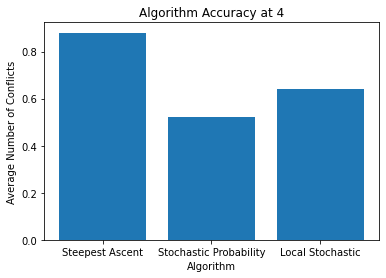

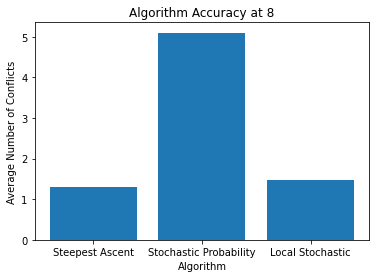

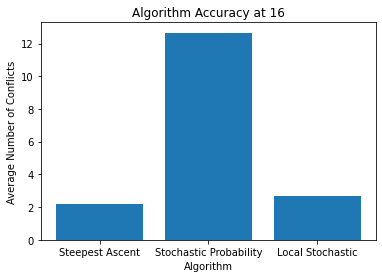

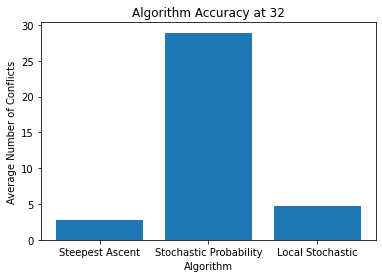

In [66]:
def avg_conflicts(N):
    avg_conflicts = []
    avg_conflicts_steepest = 0
    avg_conflicts_stochastic = 0
    avg_conflicts_local = 0
    for i in range(100):
        board = random_board(N)
        avg_conflicts_steepest += conflicts(steepest_hill_climbing(board))
        avg_conflicts_stochastic += conflicts(stochastic_hill_climbing(board))
        avg_conflicts_local += conflicts(random_local_neighbor(board))
    avg_conflicts = [avg_conflicts_steepest/100,
                     avg_conflicts_stochastic/100, avg_conflicts_local/100]
    return avg_conflicts


for i in steps:
    avg_conflict = avg_conflicts(i)
    plt.bar(names, avg_conflict)
    plt.title(f'Algorithm Accuracy at {i}')
    plt.xlabel('Algorithm')
    plt.ylabel('Average Number of Conflicts')
    plt.show()


From these charts we can determine how often an algorithm finds the lowest number of conflicts and gives us the best optimization. 

Board size 4:
Steepest ascent has the most average conflicts out of all three algorithms, with local stochastic in the middle and Stochastic probability having the least average conflicts. 
This observation is supported by analysis of the efficiency of the algorithms. In the book our class uses, their analysis predicts this observation of conflict reduction. 

Board size 8:
As the board starts to get bigger, Stochastic Probability Algorithm gets drastically worse as should be expected becuase of the need for larger and larger conflict calculations. Local stochastic stays relatively the same compared to board size 4 while Steepest ascent is getting better the larger it gets. We start to see the trend of steepest ascent and local stochastic having the same ratios of conflicts between board sizes. 

Board size 16 and 32 observations support the analysis from board size 8 where stochastic probability produces more conflicts the larger the board gets, while steepest ascent and local stochastic continue with constant accuracy. 

## Graduate student advanced task: Simulated Annealing [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


Implement simulated annealing for the n-Queens problem and compare its performance with the previouse algorithms.

Board with 8 conflicts.


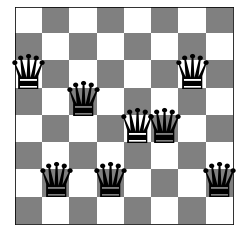

Board with 0 conflicts.


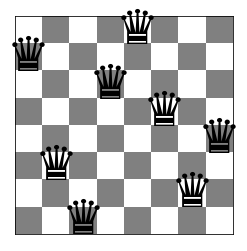

In [73]:
# Code and description go here
def simulated_annealing(board):
    current = board.copy()
    curr_conflict = conflicts(board)
    temperature = 4000
    schedule = 0.99
    while temperature > 0:
        temperature *= schedule
        for column_index in range(len(board)):
            column_moves = expand(current[column_index], current)
            move = rd.choice(column_moves)
            test_board = current.copy()
            test_board[column_index] = move
            if conflicts(test_board) < curr_conflict:
                current = test_board
                curr_conflict = conflicts(test_board)
                if curr_conflict == 0:
                    return current
            else:
                d_conflicts = conflicts(test_board) - curr_conflict
                p = e**((-1*d_conflicts)/(temperature))
                if rd.uniform(0, 1) < p:
                    current = test_board
                    curr_conflict = conflicts(test_board)
    return current


board = random_board(8)
show_board(board)
show_board(simulated_annealing(board))


## More things to do

Implement a Genetic Algorithm for the n-Queens problem.

In [13]:
# Code and description go here